## Trading System Classes

In [33]:
class Trader():
    def __init__(self, stock_exchange, capital):
        self.initial_capital = capital
        self.cash = capital
        self.portfolio = {}
        self.exchange = stock_exchange
        self.transaction_fees = 0.002
        
    def buy(self, counter, size_to_buy):
        # checks if counter even exists
        if counter in self.exchange.get_available_counters():
            # enough cash?
            if self.exchange.get_price(counter) * size_to_buy <= self.cash:
                self.cash -= (self.exchange.get_price(counter) * size_to_buy * (1+self.transaction_fees))
                if counter not in self.portfolio.keys():
                    self.portfolio[counter] = size_to_buy
                else:
                    self.portfolio[counter] += size_to_buy
            else:
                raise ValueError('Not enough money')
            pass


    def sell(self, counter, size_to_sell):
        # checks if shares exists in trader's portfolio
        if counter in self.portfolio.keys():
            # enough shares?
            if size_to_sell > 0:
                if self.portfolio[counter] >= size_to_sell:
                    #print("Cash before:")
                    #print(self.cash)
                    self.portfolio[counter] -= size_to_sell
                    #print("Cash gotten:")
                    #print(self.exchange.get_price(counter) * size_to_sell * (1-self.transaction_fees))
                    self.cash += (self.exchange.get_price(counter) * size_to_sell * (1-self.transaction_fees))
                    #print("Cash now:")
                    #print(self.cash)
                else:
                    raise ValueError('Not enough shares to sell')
    def get_portfolio_value(self):
        value = self.cash;
        for i in self.portfolio.keys():
            value = value + (self.portfolio[i] * self.exchange.get_price(i))
            #print('Date: ' + str(self.exchange.get_date()))
        return value
    
    def get_portfolio(self):
        return self.portfolio
    
    def get_max_stocks_purchasable(self, counter, funds):
        return math.floor(funds/((1+self.transaction_fees) * self.exchange.get_price(counter)))
    
    def get_cash(self):
        return self.cash
    
    def get_initial_capital(self):
        return self.initial_capital
    
    def get_profits(self):
        return self.get_portfolio_value() - self.get_initial_capital()
    
    @staticmethod
    def copy(trader):
        new_trader = Trader(trader.exchange, trader.get_initial_capital())
        new_trader.cash = trader.get_cash()
        
        if stock_symbol in trader.get_portfolio().keys():
            new_trader.portfolio = { stock_symbol : trader.get_portfolio()[stock_symbol]}
        else:
            new_trader.portfolio = {}
        new_trader.transaction_fees = 0.00175#0.002
        return new_trader
            
class Stock_Exchange():
    def __init__(self, counters):
        self.available_counters = counters # takes a list, ['aig', 'bac', 'c', 'googl_v3', 'gs', 'jpm']
        self.data = {}
        self.date = datetime.datetime.strptime('2000-01-01', "%Y-%m-%d").date()
        self.last_date = datetime.datetime.strptime('2020-01-01', "%Y-%m-%d").date()
        for i in self.available_counters:
            data = pd.read_csv('data/' + i + '.csv')
            data['Date'] = data['Date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").date())
            self.data[i] = data
            if(self.date < self.data[i]["Date"][0]):
                self.date = self.data[i]["Date"][0]
                
            if(self.last_date > self.data[i]["Date"].iloc[-1]):
                self.last_date = self.data[i]["Date"].iloc[-1]
        
        self.first_date = self.date
        
    def get_available_counters(self):
        return self.available_counters
    
    def get_price(self, counter):
        if(counter in self.available_counters):
            #print(self.data)
            val = self.data[counter].loc[self.data[counter]['Date'] == self.date]['Close']
            return list(val)[0]
        else:
            raise ValueError('Counter does not exist in exchange')
            
    def set_date(self, date, date_format):
        date = datetime.datetime.strptime(date, date_format).date()
        self.date = date
        
    def set_date(self, date):
        self.date = date
    
    def get_date(self):
        return self.date
            
    def next_day(self):
        self.date = self.date + datetime.timedelta(days=1)
        repeat = True
        while repeat:
            repeat = False
            '''for i in self.available_counters:
                if not (self.data[i]['Date'] == self.date).any():
                    #print(self.date)
                    #print('is a weekend')
                    self.date = self.date + datetime.timedelta(days=1)
                    repeat = True
                    break
            '''
            if self.date.weekday() >= 5:
                self.date = self.date + datetime.timedelta(days=1)
                repeat = True
    def get_last_date(self):
        return self.last_date
    
    def get_first_date(self):
        return self.first_date
    
    def reset(self):
        self.date = self.first_date
    
    def fast_forward(self):
        self.date = self.last_date

In [34]:
import pandas as pd
import numpy as np
import datetime
import math
import copy
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
'''risk_levels = [-1, -0.5, -0.2, 0, 0.2, 0.5, 1]

ACTION_LONG = 0
ACTION_CLOSE = 1

'''
#PARAMETERS TO CHANGE
'''

start_price_index = 2125 #2125 # this should be (25 + start_state_num from the risk_q_learning file)
duration = 700 # this should be the same as the duration in risk_q_learning
comparison_offset = 25 # this should be the same as window_size in risk_adaptive_trading_data_generation
stock_symbol = 'bac'
capital = 10000
''''''

trading_patterns_dir = './trading_patterns/'
trading_patterns = []
trading_patterns_dict = {}
for level in risk_levels:    
    actions_data = pd.read_csv(trading_patterns_dir + stock_symbol + '_' + str(level) + '_' + str(start_price_index) + '_to_' + str(start_price_index + duration) + '.csv')
    actions_data['Date'] = actions_data['Date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").date())
    trading_patterns_dict[level] = {}
    for index, row in actions_data[start_price_index:start_price_index+duration].iterrows():
        trading_patterns_dict[level][row['Date']] = row['trading_action']
    #actions_data[['Date', 'trading_action']][start_price_index:start_price_index+duration].reset_index(drop=True)
    trading_patterns.append(actions_data[['Date', 'trading_action']][start_price_index:start_price_index+duration].reset_index(drop=True))

exchange = Stock_Exchange([stock_symbol])
secondary_exchange = Stock_Exchange([stock_symbol])
'''

'\n\nstart_price_index = 2125 #2125 # this should be (25 + start_state_num from the risk_q_learning file)\nduration = 700 # this should be the same as the duration in risk_q_learning\ncomparison_offset = 25 # this should be the same as window_size in risk_adaptive_trading_data_generation\nstock_symbol = \'bac\'\ncapital = 10000\n\n\ntrading_patterns_dir = \'./trading_patterns/\'\ntrading_patterns = []\ntrading_patterns_dict = {}\nfor level in risk_levels:    \n    actions_data = pd.read_csv(trading_patterns_dir + stock_symbol + \'_\' + str(level) + \'_\' + str(start_price_index) + \'_to_\' + str(start_price_index + duration) + \'.csv\')\n    actions_data[\'Date\'] = actions_data[\'Date\'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").date())\n    trading_patterns_dict[level] = {}\n    for index, row in actions_data[start_price_index:start_price_index+duration].iterrows():\n        trading_patterns_dict[level][row[\'Date\']] = row[\'trading_action\']\n    #actions_data[[\'Da

In [36]:
risk_levels = [-1, -0.5, -0.2, 0, 0.2, 0.5, 1]

ACTION_LONG = 0
ACTION_CLOSE = 1

'''
PARAMETERS TO CHANGE
'''
start_price_indexes = [25, 725, 1425] # this should be (25 + start_state_num from the risk_q_learning file)
duration_for_each = 700 # this should be the same as the duration in risk_q_learning
comparison_offset = 25 # this should be the same as window_size in risk_adaptive_trading_data_generation
stock_symbol = 'spy'
capital = 10000
''''''

trading_patterns_dir = './trading_patterns/'
training_data_dir = './training_data/'
trading_patterns = []
trading_patterns_dict = {}

dates = []
populated_dates = False
for level in risk_levels:    
    trading_patterns_dict[level] = {}
    
    for start_price_index in start_price_indexes:
        actions_data = pd.read_csv(trading_patterns_dir + stock_symbol + '_' + str(level) + '_' + str(start_price_index) + '_to_' + str(start_price_index + duration_for_each) + '.csv')
        actions_data['Date'] = actions_data['Date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").date())

        for index, row in actions_data[start_price_index:start_price_index+duration_for_each].iterrows():
            trading_patterns_dict[level][row['Date']] = row['trading_action']
            if populated_dates is False:
                dates.append(row['Date'])
                
    populated_dates = True
exchange = Stock_Exchange([stock_symbol])
secondary_exchange = Stock_Exchange([stock_symbol])

In [37]:
# CHECK PROFITS OF EACH RISK LEVEL
for risk_level in risk_levels:
    gupta = Trader(exchange, capital)
    print('Risk Level: ' + str(risk_level))
    for date in list(trading_patterns_dict[risk_level].keys())[comparison_offset:]:
        exchange.set_date(date)
        action = trading_patterns_dict[risk_level][date]
        if action == ACTION_LONG:
            stocks_to_buy = gupta.get_max_stocks_purchasable(stock_symbol, gupta.get_cash())
            gupta.buy(stock_symbol, stocks_to_buy)
        elif action == ACTION_CLOSE:
            if stock_symbol in gupta.get_portfolio().keys():
                gupta.sell(stock_symbol, gupta.get_portfolio()[stock_symbol])
            
    print(gupta.get_portfolio_value()- gupta.initial_capital)
    print(str(((gupta.get_portfolio_value()- gupta.initial_capital) / gupta.initial_capital) * 100) + '%')
    exchange.reset()

Risk Level: -1
-39.68799868000133
-0.3968799868000133%
Risk Level: -0.5
1004.2301890700055
10.042301890700054%
Risk Level: -0.2
-239.80897327399907
-2.3980897327399906%
Risk Level: 0
2650.175102668003
26.501751026680033%
Risk Level: 0.2
480.94006789399646
4.809400678939965%
Risk Level: 0.5
380.8547325400159
3.808547325400159%
Risk Level: 1
-1003.5493743460029
-10.035493743460028%


In [38]:
### find best model on this date
def find_best_model(dates):
    best_model = None
    best_profit = None
    for i in risk_levels:
            
        tmp_dict = {}
        tmp_dict['Date'] = dates
        tmp_dict['trading_action'] = []
        for day in dates:
            tmp_dict['trading_action'].append(trading_patterns_dict[i][day])
        
        profit = calculate_profit(pd.DataFrame(tmp_dict))
        if best_model is None or profit > best_profit:
            best_profit = profit
            best_model = i
    return best_model
            
            
def calculate_profit(a_trading_pattern):
    mock_trader = Trader(secondary_exchange, capital)
    trade(a_trading_pattern, mock_trader)
    return mock_trader.get_portfolio_value() - mock_trader.get_initial_capital()
    

def trade(a_trading_pattern, mock_trader):
    for index, row in a_trading_pattern.iterrows():
        secondary_exchange.set_date(row['Date'])
        if row['trading_action'] == ACTION_LONG:
            stocks_to_buy = mock_trader.get_max_stocks_purchasable(stock_symbol, mock_trader.get_cash())
            mock_trader.buy(stock_symbol, stocks_to_buy)
        elif row['trading_action'] == ACTION_CLOSE:
            if stock_symbol in mock_trader.get_portfolio().keys():
                mock_trader.sell(stock_symbol, mock_trader.get_portfolio()[stock_symbol])

## Gupta's Risk Adaptive

In [44]:
exchange.reset()
gupta = Trader(exchange, capital)
gupta_window = 21
for i in range(comparison_offset,len(dates)):
    exchange.set_date(dates[i])
    best_risk_model = find_best_model(dates[i:i-gupta_window])
    action = trading_patterns_dict[best_risk_model][dates[i]]
    if action == ACTION_LONG:
            stocks_to_buy = gupta.get_max_stocks_purchasable(stock_symbol, gupta.get_cash())
            gupta.buy(stock_symbol, stocks_to_buy)
    elif action == ACTION_CLOSE:
        if stock_symbol in gupta.get_portfolio().keys():
            gupta.sell(stock_symbol, gupta.get_portfolio()[stock_symbol])
    print(str(i) + '/' + str(len(dates)))
print('Profit:' + str(gupta.get_portfolio_value()-gupta.get_initial_capital()))

25/2100
26/2100
27/2100
28/2100
29/2100
30/2100
31/2100
32/2100
33/2100
34/2100
35/2100
36/2100
37/2100
38/2100
39/2100
40/2100
41/2100
42/2100
43/2100
44/2100
45/2100
46/2100
47/2100
48/2100
49/2100
50/2100
51/2100
52/2100
53/2100
54/2100
55/2100
56/2100
57/2100
58/2100
59/2100
60/2100
61/2100
62/2100
63/2100
64/2100
65/2100
66/2100
67/2100
68/2100
69/2100
70/2100
71/2100
72/2100
73/2100
74/2100
75/2100
76/2100
77/2100
78/2100
79/2100
80/2100
81/2100
82/2100
83/2100
84/2100
85/2100
86/2100
87/2100
88/2100
89/2100
90/2100
91/2100
92/2100
93/2100
94/2100
95/2100
96/2100
97/2100
98/2100
99/2100
100/2100
101/2100
102/2100
103/2100
104/2100
105/2100
106/2100
107/2100
108/2100
109/2100
110/2100
111/2100
112/2100
113/2100
114/2100
115/2100
116/2100
117/2100
118/2100
119/2100
120/2100
121/2100
122/2100
123/2100
124/2100
125/2100
126/2100
127/2100
128/2100
129/2100
130/2100
131/2100
132/2100
133/2100
134/2100
135/2100
136/2100
137/2100
138/2100
139/2100
140/2100
141/2100
142/2100
143/2100
144/

978/2100
979/2100
980/2100
981/2100
982/2100
983/2100
984/2100
985/2100
986/2100
987/2100
988/2100
989/2100
990/2100
991/2100
992/2100
993/2100
994/2100
995/2100
996/2100
997/2100
998/2100
999/2100
1000/2100
1001/2100
1002/2100
1003/2100
1004/2100
1005/2100
1006/2100
1007/2100
1008/2100
1009/2100
1010/2100
1011/2100
1012/2100
1013/2100
1014/2100
1015/2100
1016/2100
1017/2100
1018/2100
1019/2100
1020/2100
1021/2100
1022/2100
1023/2100
1024/2100
1025/2100
1026/2100
1027/2100
1028/2100
1029/2100
1030/2100
1031/2100
1032/2100
1033/2100
1034/2100
1035/2100
1036/2100
1037/2100
1038/2100
1039/2100
1040/2100
1041/2100
1042/2100
1043/2100
1044/2100
1045/2100
1046/2100
1047/2100
1048/2100
1049/2100
1050/2100
1051/2100
1052/2100
1053/2100
1054/2100
1055/2100
1056/2100
1057/2100
1058/2100
1059/2100
1060/2100
1061/2100
1062/2100
1063/2100
1064/2100
1065/2100
1066/2100
1067/2100
1068/2100
1069/2100
1070/2100
1071/2100
1072/2100
1073/2100
1074/2100
1075/2100
1076/2100
1077/2100
1078/2100
1079/2100
10

1874/2100
1875/2100
1876/2100
1877/2100
1878/2100
1879/2100
1880/2100
1881/2100
1882/2100
1883/2100
1884/2100
1885/2100
1886/2100
1887/2100
1888/2100
1889/2100
1890/2100
1891/2100
1892/2100
1893/2100
1894/2100
1895/2100
1896/2100
1897/2100
1898/2100
1899/2100
1900/2100
1901/2100
1902/2100
1903/2100
1904/2100
1905/2100
1906/2100
1907/2100
1908/2100
1909/2100
1910/2100
1911/2100
1912/2100
1913/2100
1914/2100
1915/2100
1916/2100
1917/2100
1918/2100
1919/2100
1920/2100
1921/2100
1922/2100
1923/2100
1924/2100
1925/2100
1926/2100
1927/2100
1928/2100
1929/2100
1930/2100
1931/2100
1932/2100
1933/2100
1934/2100
1935/2100
1936/2100
1937/2100
1938/2100
1939/2100
1940/2100
1941/2100
1942/2100
1943/2100
1944/2100
1945/2100
1946/2100
1947/2100
1948/2100
1949/2100
1950/2100
1951/2100
1952/2100
1953/2100
1954/2100
1955/2100
1956/2100
1957/2100
1958/2100
1959/2100
1960/2100
1961/2100
1962/2100
1963/2100
1964/2100
1965/2100
1966/2100
1967/2100
1968/2100
1969/2100
1970/2100
1971/2100
1972/2100
1973/2100


## Mine

In [46]:
def get_processed_data(technical_indicated_file):
    std_span = 10
    # Data reading and preprocessing
    data =  pd.read_csv(technical_indicated_file)
    data['Date'] = data['Date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").date())
    small_data = data
    x = small_data['Date']

    # Calculating std (sigma)
    std = pd.DataFrame()
    std['Date'] = small_data['Date']
    std['Rolling-STD'] = small_data["EMA-12-Close"].rolling(std_span).std()
    
    # PCT_CHANGE
    small_data['Pct_Change'] = small_data['EMA-12-Close'].pct_change()
    small_data['Abs_Pct_Change'] = abs(small_data['EMA-12-Close'].pct_change())
    small_data['Pct_Change_Vol'] = small_data['EMA-12-Volume'].pct_change()

    """
    Calculating volatility
    """
    crashes_k = pd.DataFrame()
    crashes_k["Date"] = small_data["Date"]
    crashes_k["crashes_k"] = small_data['neg_and_above_threshold'] * 1


    """ 
    Using PPO for Timing
    """
    # neg_k = 1 when trigger goes on top of PPO line (Red)
    # pos_k = 1 when trigger goes below PPO line (Green)

    d = (small_data["PPO"] - small_data["PPO-EMA-Trigger"])

    # PPO Buy and Sell Signals
    ppo_above = pd.Series(np.nan, index=list(range(0,small_data.shape[0])))
    ppo_below = pd.Series(np.nan, index=list(range(0,small_data.shape[0])))
    ppo_buy_signals = pd.Series(np.nan, index=list(range(0,small_data.shape[0])))
    ppo_sell_signals = pd.Series(np.nan, index=list(range(0,small_data.shape[0])))


    d = (small_data["PPO"] - small_data["PPO-EMA-Trigger"])
    for i in range(1, len(d) - 1):
        if d[i] * d[i - 1] < 0.:
            # crossover at i
            if(d[i] > 0.):
                ppo_above[i] = small_data.loc[i, "PPO-EMA-Trigger"]
                ppo_buy_signals[i] = small_data.loc[i, "Date"]
            else:
                ppo_below[i] = small_data.loc[i, "PPO-EMA-Trigger"]
                ppo_sell_signals[i] = small_data.loc[i, "Date"]

    #ppo_buy_signals.to_csv(folder + counter + "-ppo-buy.csv", index=False)
    #ppo_sell_signals.to_csv(folder + counter + "-ppo-sell.csv", index=False)


    # Caclulating ppo_k
    ppo_k = pd.DataFrame()

    # Populating std
    ppo_k['std'] = std['Rolling-STD']

    # Filling pos_k and neg_k with 1
    ppo_k["Date"] = small_data["Date"]
    ppo_k["pos_k"] = pd.Series(np.nan, index=list(range(0,ppo_k.shape[0])))
    ppo_k["pos_k"].loc[ppo_k["Date"] == ppo_buy_signals] = 1

    ppo_k["neg_k"] = pd.Series(np.nan, index=list(range(0,ppo_k.shape[0])))
    ppo_k["neg_k"].loc[ppo_k["Date"] == ppo_sell_signals] = 1
    assert(all(std["Date"] == ppo_k["Date"]))

    # Filling ppo_k dataframe with t to help speed up calculation during half-life
    # Init t as 0 for dates where ppo signals
    ppo_k["pos_k_t"] = pd.Series(np.nan, index=list(range(0,ppo_k.shape[0])))
    ppo_k["pos_k_t"].loc[ppo_k["pos_k"] == 1] = 0

    ppo_k["neg_k_t"] = pd.Series(np.nan, index=list(range(0,ppo_k.shape[0])))
    ppo_k["neg_k_t"].loc[ppo_k["neg_k"] == 1] = 0

    # Identify first pos_k and first neg_k
    first_pos_k_index = ppo_k['pos_k'].idxmax()
    first_neg_k_index = ppo_k['neg_k'].idxmax()

    # Populating ppo t values 
    tmp = ppo_k.copy()
    i = 0
    while ppo_k["pos_k_t"][first_pos_k_index:].isnull().values.any() or ppo_k["neg_k_t"][first_neg_k_index:].isnull().values.any():
        i+=1
        tmp = tmp.shift()
        ppo_k["pos_k_t"].loc[(tmp["pos_k"] == 1) & (ppo_k["pos_k_t"].isnull())] = i
        ppo_k["neg_k_t"].loc[(tmp["neg_k"] == 1) & (ppo_k["neg_k_t"].isnull())] = i


    """
    Using RSI for Timing
    """
    # neg_k = 1 when above 70 (Overbought)
    # pos_k = 1 when above 30 (Oversold)
    overbought = pd.Series(np.nan, index=list(range(0,small_data.shape[0])))
    oversold = pd.Series(np.nan, index=list(range(0,small_data.shape[0])))
    rsi_buy_signals = pd.Series(np.nan, index=list(range(0,small_data.shape[0])))
    rsi_sell_signals = pd.Series(np.nan, index=list(range(0,small_data.shape[0])))

    d_overbought = (70 - small_data["RSI"])
    for i in range(1, len(d_overbought) - 1):
        '''if d_overbought[i] * d_overbought[i - 1] < 0.:
                # crossover at i
                if d_overbought[i] < 0.:
                    rsi_sell_signals[i] = small_data.loc[i, "Date"]
                    overbought[i] = 70 #small_data.loc[i, "RSI"]'''
        if(d_overbought[i] < 0):
            rsi_sell_signals[i] = small_data.loc[i, "Date"]




    d_oversold = (30 - small_data["RSI"])
    for i in range(1, len(d_oversold) - 1):
        '''if d_oversold[i] * d_oversold[i - 1] < 0.:
                # crossover at i
                if d_oversold[i] > 0.:
                    rsi_buy_signals[i] = small_data.loc[i, "Date"]
                    oversold[i] = 30 #small_data.loc[i, "RSI"]'''
        if(d_oversold[i] > 0):
            rsi_buy_signals[i] = small_data.loc[i, "Date"]



    # Caclulating rsi_k
    rsi_k = pd.DataFrame()

    # Populating std
    rsi_k['std'] = std['Rolling-STD']

    # Filling pos_k and neg_k with 1
    rsi_k["Date"] = small_data["Date"]
    rsi_k["pos_k"] = pd.Series(np.nan, index=list(range(0,rsi_k.shape[0])))
    rsi_k["pos_k"].loc[rsi_k["Date"] == rsi_buy_signals] = 1

    rsi_k["neg_k"] = pd.Series(np.nan, index=list(range(0,rsi_k.shape[0])))
    rsi_k["neg_k"].loc[rsi_k["Date"] == rsi_sell_signals] = 1
    assert(all(std["Date"] == rsi_k["Date"]))


    # Filling rsi_k dataframe with t to help speed up calculation during half-life
    # Init t as 0 for dates where rsi signals
    rsi_k["pos_k_t"] = pd.Series(np.nan, index=list(range(0,rsi_k.shape[0])))
    rsi_k["pos_k_t"].loc[rsi_k["pos_k"] == 1] = 0

    rsi_k["neg_k_t"] = pd.Series(np.nan, index=list(range(0,rsi_k.shape[0])))
    rsi_k["neg_k_t"].loc[rsi_k["neg_k"] == 1] = 0

    # Identify first pos_k and first neg_k
    first_pos_k_index = rsi_k['pos_k'].idxmax()
    first_neg_k_index = rsi_k['neg_k'].idxmax()

    # Populating rsi t values 
    tmp = rsi_k.copy()
    i = 0
    while rsi_k["pos_k_t"][first_pos_k_index:].isnull().values.any() or rsi_k["neg_k_t"][first_neg_k_index:].isnull().values.any():
        i+=1
        tmp = tmp.shift()
        rsi_k["pos_k_t"].loc[(tmp["pos_k"] == 1) & (rsi_k["pos_k_t"].isnull())] = i
        rsi_k["neg_k_t"].loc[(tmp["neg_k"] == 1) & (rsi_k["neg_k_t"].isnull())] = i
    
    return ppo_k, rsi_k, crashes_k, small_data, ppo_buy_signals, ppo_sell_signals, rsi_buy_signals, rsi_sell_signals

def get_combined_k(decay_alpha_ppo, decay_alpha_rsi, ppo_k, rsi_k, technical_data, crashes_k):
    """
    Generate combined pos_k and neg_k based on given decay_alpha
    """
    
    assert(len(ppo_k) == len(rsi_k) and len(technical_data) == len(crashes_k) and len(technical_data == len(ppo_k)))
    
    # Decay ppo_k using half-life 
    ppo_k["pos_k_hl"] = ppo_k["pos_k"]
    ppo_k["neg_k_hl"] = ppo_k["neg_k"]

    tmp = (-1 * decay_alpha_ppo * technical_data['Abs_Pct_Change'])
    
    ppo_k["pos_k_hl"] = (math.e ** (tmp * ppo_k["pos_k_t"])) # * 1.0 (omitted) where 1.0 is the N(0)
    ppo_k["neg_k_hl"] = (math.e ** (tmp * ppo_k["neg_k_t"])) # * 1.0 (omitted) where 1.0 is the N(0)
    
    '''ppo_k["pos_k_hl"] = 1.0 * (math.e ** (-1 * decay_alpha_ppo * (technical_data['pct_change_vol'] * 1000) * technical_data['pct_change'] * ppo_k["pos_k_t"])) 
    ppo_k["neg_k_hl"] = 1.0 * (math.e ** (-1 * decay_alpha_ppo * (technical_data['pct_change_vol'] * 1000) * technical_data['pct_change'] * ppo_k["neg_k_t"]))
    '''
    # Decay rsi_k using half-life 
    rsi_k["pos_k_hl"] = rsi_k["pos_k"]
    rsi_k["neg_k_hl"] = rsi_k["neg_k"]
    
    tmp = (-1 * decay_alpha_rsi * technical_data['Abs_Pct_Change'])

    rsi_k["pos_k_hl"] = (math.e ** (tmp * rsi_k["pos_k_t"])) # * 1.0 (omitted) where 1.0 is the N(0)
    rsi_k["neg_k_hl"] = (math.e ** (tmp * rsi_k["neg_k_t"])) # * 1.0 (omitted) where 1.0 is the N(0)
    
    '''rsi_k["pos_k_hl"] = 1.0 * (math.e ** (-1 * decay_alpha_rsi * (technical_data['pct_change_vol'] * 1000) * technical_data['pct_change'] * rsi_k["pos_k_t"])) 
    rsi_k["neg_k_hl"] = 1.0 * (math.e ** (-1 * decay_alpha_rsi * (technical_data['pct_change_vol'] * 1000) * technical_data['pct_change'] * rsi_k["neg_k_t"]))
    '''
    #print(rsi_k["pos_k_hl"])
    #rsi_k.to_csv(folder + counter + "-rsi.csv")
    #ppo_k.to_csv(folder + counter + "-ppo.csv")

    # Combining PPO_K and RSI_K
    assert(all(ppo_k["Date"] == rsi_k["Date"]) and all(ppo_k["Date"] == technical_data["Date"]) and all(crashes_k["Date"] == ppo_k["Date"]))
    
    combined_k = pd.DataFrame()
    combined_k["Date"] = technical_data["Date"]
    combined_k["pos_k_hl"] = ppo_k["pos_k_hl"].fillna(0) * rsi_k["pos_k_hl"].fillna(0)
    combined_k["neg_k_hl"] = pow(ppo_k["neg_k_hl"].fillna(0) * rsi_k["neg_k_hl"].fillna(0), 1-crashes_k["crashes_k"])
    #combined_k["neg_k_hl"] = ppo_k["neg_k_hl"].fillna(0) * rsi_k["neg_k_hl"].fillna(0)


    # Using ADX & DMI
    # Irrespective of whether the trader takes a long or short position, 
    # the ADX should be over 25 when the crossover occurs to confirm the trend’s strength. 
    combined_k["pos_k_hl_copy"] = combined_k["pos_k_hl"]
    combined_k["neg_k_hl_copy"] = combined_k["neg_k_hl"]

    assert(all(combined_k["Date"]==technical_data["Date"]))

    
    '''combined_k["neg_k_hl_copy"].loc[(technical_data["NEG_DI14"] > technical_data["POS_DI14"]) & (technical_data["ADX"] >= 40)] = combined_k["neg_k_hl_copy"] * 1.0
    combined_k["neg_k_hl_copy"].loc[(technical_data["NEG_DI14"] > technical_data["POS_DI14"]) & (technical_data["ADX"] >= 30) & (technical_data["ADX"] < 40)] = combined_k["neg_k_hl_copy"] * 0.5
    combined_k["neg_k_hl_copy"].loc[(technical_data["NEG_DI14"] > technical_data["POS_DI14"]) & (technical_data["ADX"] >= 20) & (technical_data["ADX"] < 30)] = combined_k["neg_k_hl_copy"] * 0.25
    
    combined_k["pos_k_hl_copy"].loc[(technical_data["POS_DI14"] > technical_data["NEG_DI14"]) & (technical_data["ADX"] >= 40)] = combined_k["pos_k_hl_copy"] * 1.0
    combined_k["pos_k_hl_copy"].loc[(technical_data["POS_DI14"] > technical_data["NEG_DI14"]) & (technical_data["ADX"] >= 30) & (technical_data["ADX"] < 40)] = combined_k["pos_k_hl_copy"] * 0.5
    combined_k["pos_k_hl_copy"].loc[(technical_data["POS_DI14"] > technical_data["NEG_DI14"]) & (technical_data["ADX"] >= 20) & (technical_data["ADX"] < 30)] = combined_k["pos_k_hl_copy"] * 0.25
    '''
    
    
    
    combined_k["neg_k_hl_copy"].loc[(technical_data["NEG_DI14"] > technical_data["POS_DI14"]) & (technical_data["ADX"] >= 20)] = combined_k["neg_k_hl"] * 0.25
    combined_k["neg_k_hl_copy"].loc[(technical_data["NEG_DI14"] > technical_data["POS_DI14"]) & (technical_data["ADX"] >= 30)] = combined_k["neg_k_hl"] * 0.5
    combined_k["neg_k_hl_copy"].loc[(technical_data["NEG_DI14"] > technical_data["POS_DI14"]) & (technical_data["ADX"] >= 40)] = combined_k["neg_k_hl"] * 1.0
    
    combined_k["pos_k_hl_copy"].loc[(technical_data["POS_DI14"] > technical_data["NEG_DI14"]) & (technical_data["ADX"] >= 20)] = combined_k["pos_k_hl"] * 0.25
    combined_k["pos_k_hl_copy"].loc[(technical_data["POS_DI14"] > technical_data["NEG_DI14"]) & (technical_data["ADX"] >= 30)] = combined_k["pos_k_hl"] * 0.5
    combined_k["pos_k_hl_copy"].loc[(technical_data["POS_DI14"] > technical_data["NEG_DI14"]) & (technical_data["ADX"] >= 40)] = combined_k["pos_k_hl"] * 1.0
    
    # Make it mutually exlusive
    combined_k["neg_k_hl_copy"].loc[(technical_data["POS_DI14"] > technical_data["NEG_DI14"]) & (technical_data["ADX"] > 20)] = 0
    combined_k["pos_k_hl_copy"].loc[(technical_data["POS_DI14"] < technical_data["NEG_DI14"]) & (technical_data["ADX"] > 20)] = 0

    # Trend not strong enough
    combined_k["neg_k_hl_copy"].loc[(technical_data["ADX"] < 20)] = 0
    combined_k["pos_k_hl_copy"].loc[(technical_data["ADX"] < 20)] = 0

    # combined_k.to_csv(folder + counter + "-combined.csv", index=False)
    return combined_k

In [47]:
def closest_k(k):
    closest_risk = None
    closest_distance = None
    for risk_level in risk_levels:
        distance = abs(k-risk_level)
        if closest_risk is None or distance < closest_distance:
            closest_distance = distance
            closest_risk = risk_level
    return closest_risk

def to_action(row):
    date = row['Date']
    risk_level = row['k']
    tmp_pattern = trading_patterns_dict[risk_level]
    return tmp_pattern[date]
    #return tmp_pattern.loc[tmp_pattern['Date'] == date]['trading_action'].values[0]

In [50]:
exchange.reset()
jingyang = Trader(exchange, capital)
folder = "./temp/"
ppo_k, rsi_k, crashes_k, technical_data, tmp_ppo_buy_dates, tmp_ppo_sell_dates, tmp_rsi_buy_dates, tmp_rsi_sell_dates = get_processed_data(folder+stock_symbol+'-technical-indicated.csv')

tmp_start_date = dates[comparison_offset]
tmp_end_date = dates[-1]

start_date_index = technical_data.index[technical_data['Date'] == tmp_start_date].tolist()[0] 
end_date_index = technical_data.index[technical_data['Date'] == tmp_end_date].tolist()[0] 

c:\users\jing yang\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [42]:
#PPO Trader

ppo_buy_dates = pd.DataFrame(tmp_ppo_buy_dates[start_date_index:end_date_index+1])
ppo_sell_dates = pd.DataFrame(tmp_ppo_sell_dates[start_date_index:end_date_index+1])

assert(len(ppo_buy_dates) == len(dates) - comparison_offset)
assert(len(ppo_sell_dates) == len(dates) - comparison_offset)

ppo_buy_dates.columns = ['Date']
ppo_sell_dates.columns = ['Date']

ppo_buy_dates.dropna(inplace=True)
ppo_sell_dates.dropna(inplace=True)

ppo_buy_dates = ppo_buy_dates.reset_index(drop=True)
ppo_sell_dates = ppo_sell_dates.reset_index(drop=True)


exchange.reset()
ppo_trader = Trader(exchange, capital)


sell_index = 0
for idx, row in ppo_buy_dates.iterrows():
    exchange.set_date(row['Date'])
    qty_to_buy = ppo_trader.get_max_stocks_purchasable(stock_symbol, ppo_trader.get_cash())
    #print('Buying ' + str(qty_to_buy) + ' on ' + str(row['Date']) + ' for ' + str(exchange.get_price(stock_symbol)))
    ppo_trader.buy(stock_symbol, qty_to_buy)
    
    while(True):
        if sell_index >= ppo_sell_dates.shape[0]:
            break
        assert(row['Date']!=ppo_sell_dates.loc[sell_index]['Date'])
        sell_date = ppo_sell_dates.loc[sell_index]['Date']
        
        # If sell date is later than the next buy date
        if idx+1<ppo_buy_dates.shape[0] and sell_date > ppo_buy_dates.loc[idx+1]['Date']:
            break
        
        # If sell date is earlier than the next buy date
        if idx+1==ppo_buy_dates.shape[0] or sell_date < ppo_buy_dates.loc[idx+1]['Date']:
            # If sell date is later than today
            if sell_date > row['Date']:
                exchange.set_date(sell_date)
                qty_on_hand = 0
                if(stock_symbol in ppo_trader.get_portfolio().keys()):
                    qty_on_hand = ppo_trader.get_portfolio()[stock_symbol]
                    
                qty_to_sell = qty_on_hand
                #print('Selling ' + str(qty_to_sell) + ' on ' + str(sell_date) + ' for ' + str(exchange.get_price(stock_symbol)))
                ppo_trader.sell(stock_symbol, qty_to_sell)
                sell_index+=1 
                break
            # If sell date is earlier than today
            if sell_date < row['Date']:
                sell_index+=1

#fast forward
exchange.set_date(tmp_end_date)
print(ppo_trader.get_portfolio_value()-ppo_trader.get_initial_capital())
print(str(((ppo_trader.get_portfolio_value()- ppo_trader.initial_capital) / ppo_trader.initial_capital) * 100) + '%')

-1842.869688806013
-18.42869688806013%


In [51]:
# RSI Trader

rsi_buy_dates = pd.DataFrame(tmp_rsi_buy_dates[start_date_index:end_date_index+1])
rsi_sell_dates = pd.DataFrame(tmp_rsi_sell_dates[start_date_index:end_date_index+1])

assert(len(rsi_buy_dates) == len(dates) - comparison_offset)
assert(len(rsi_sell_dates) == len(dates) - comparison_offset)

rsi_buy_dates.columns = ['Date']
rsi_sell_dates.columns = ['Date']

rsi_buy_dates.dropna(inplace=True)
rsi_sell_dates.dropna(inplace=True)

rsi_buy_dates = rsi_buy_dates.reset_index(drop=True)
rsi_sell_dates = rsi_sell_dates.reset_index(drop=True)


exchange.reset()
rsi_trader = Trader(exchange, capital)

sell_index = 0
for idx, row in rsi_buy_dates.iterrows():
    exchange.set_date(row['Date'])
    qty_to_buy = rsi_trader.get_max_stocks_purchasable(stock_symbol, rsi_trader.get_cash())
    #print('Buying ' + str(qty_to_buy) + ' on ' + str(row['Date']) + ' for ' + str(exchange.get_price(stock_symbol)))
    rsi_trader.buy(stock_symbol, qty_to_buy)
    
    while(True):
        if sell_index >= rsi_sell_dates.shape[0]:
            break
        assert(row['Date']!=rsi_sell_dates.loc[sell_index]['Date'])
        sell_date = rsi_sell_dates.loc[sell_index]['Date']
        
        # If sell date is later than the next buy date
        if idx+1<rsi_buy_dates.shape[0] and sell_date > rsi_buy_dates.loc[idx+1]['Date']:
            break
        
        # If sell date is earlier than the next buy date
        if idx+1==rsi_buy_dates.shape[0] or sell_date < rsi_buy_dates.loc[idx+1]['Date']:
            # If sell date is later than today
            if sell_date > row['Date']:
                exchange.set_date(sell_date)
                qty_on_hand = 0
                if(stock_symbol in rsi_trader.get_portfolio().keys()):
                    qty_on_hand = rsi_trader.get_portfolio()[stock_symbol]
                    
                qty_to_sell = qty_on_hand
                #print('Selling ' + str(qty_to_sell) + ' on ' + str(sell_date) + ' for ' + str(exchange.get_price(stock_symbol)))
                rsi_trader.sell(stock_symbol, qty_to_sell)
                sell_index+=1 
                break
            # If sell date is earlier than today
            if sell_date < row['Date']:
                sell_index+=1

#fast forward
exchange.set_date(tmp_end_date)
print(rsi_trader.get_portfolio_value()-rsi_trader.get_initial_capital())
print(str(((rsi_trader.get_portfolio_value()- rsi_trader.initial_capital) / rsi_trader.initial_capital) * 100) + '%')

-3000.4100838800014
-30.004100838800014%


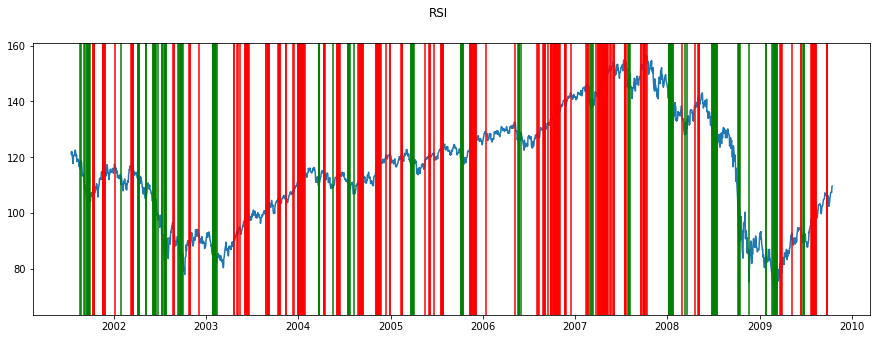

In [80]:
tmp = technical_data[start_date_index:end_date_index+1]
fig = plt.figure(figsize=(15,5))
plt.plot(tmp['Date'],tmp['Close'], figure=fig)
plt.suptitle('RSI')
for index, row in rsi_buy_dates.iterrows():
    plt.axvline(row['Date'], color='g', linestyle='-', figure=fig)
for index, row in rsi_sell_dates.iterrows():
    plt.axvline(row['Date'], color='r', linestyle='-', figure=fig)


plt.show()

In [43]:
# Buy & Hold Trader
exchange.reset()
buy_hold_trader = Trader(exchange, capital)
exchange.set_date(tmp_start_date)
qty_to_buy = buy_hold_trader.get_max_stocks_purchasable(stock_symbol, buy_hold_trader.get_cash())
buy_hold_trader.buy(stock_symbol, qty_to_buy)
exchange.set_date(tmp_end_date)
print(buy_hold_trader.get_portfolio_value()-buy_hold_trader.get_initial_capital())
print(str(((buy_hold_trader.get_portfolio_value()- buy_hold_trader.initial_capital) / buy_hold_trader.initial_capital) * 100) + '%')
exchange.reset()

-1002.2678363520008
-10.022678363520008%


### Simple search for optimal parameters

In [9]:
#%%timeit
best_profit = None
best_ppo_decay = None
best_rsi_decay = None
profits = []

truncated_ppo_k = ppo_k[start_date_index:end_date_index+1].reset_index(drop=True)
truncated_rsi_k = rsi_k[start_date_index:end_date_index+1].reset_index(drop=True)
truncated_crashes_k = crashes_k[start_date_index:end_date_index+1].reset_index(drop=True)
truncated_technical_data = technical_data[start_date_index:end_date_index+1].reset_index(drop=True)

'''for multiplier_ppo in range(1, 30, 1):     
    for multiplier_rsi in range(1, 30, 1): 
        combined_k = get_combined_k(decay_alpha_ppo=multiplier_ppo, decay_alpha_rsi=multiplier_rsi, ppo_k=truncated_ppo_k, rsi_k=truncated_rsi_k, technical_data=truncated_technical_data, crashes_k=truncated_crashes_k)
        combined_k['k'] = 0
        combined_k['k'].loc[combined_k['pos_k_hl_copy'] > combined_k['neg_k_hl_copy']] = combined_k['pos_k_hl_copy'] 
        combined_k['k'].loc[combined_k['neg_k_hl_copy'] > combined_k['pos_k_hl_copy']] = -1 * combined_k['neg_k_hl_copy'] 

        combined_k['k'] = combined_k['k'].apply(closest_k)
        combined_k['trading_action'] = 0
        combined_k['trading_action'] = combined_k.apply(to_action, axis=1)

        print(stock_symbol + '- ppo_decay : ' + str(multiplier_ppo) + ', rsi_decay : ' + str(multiplier_rsi))
        profit = calculate_profit(combined_k)
        print(profit)
        
        if best_profit is None or profit > best_profit:
            best_profit = profit
            best_ppo_decay = multiplier_ppo
            best_rsi_decay = multiplier_rsi
        
        profits.append(profit)


print("Best Profit: " + str(best_profit))
print("Best PPO_DECAY: " + str(best_ppo_decay))
print("Best RSI_DECAY: " + str(best_rsi_decay))
'''

'for multiplier_ppo in range(1, 30, 1):     \n    for multiplier_rsi in range(1, 30, 1): \n        combined_k = get_combined_k(decay_alpha_ppo=multiplier_ppo, decay_alpha_rsi=multiplier_rsi, ppo_k=truncated_ppo_k, rsi_k=truncated_rsi_k, technical_data=truncated_technical_data, crashes_k=truncated_crashes_k)\n        combined_k[\'k\'] = 0\n        combined_k[\'k\'].loc[combined_k[\'pos_k_hl_copy\'] > combined_k[\'neg_k_hl_copy\']] = combined_k[\'pos_k_hl_copy\'] \n        combined_k[\'k\'].loc[combined_k[\'neg_k_hl_copy\'] > combined_k[\'pos_k_hl_copy\']] = -1 * combined_k[\'neg_k_hl_copy\'] \n\n        combined_k[\'k\'] = combined_k[\'k\'].apply(closest_k)\n        combined_k[\'trading_action\'] = 0\n        combined_k[\'trading_action\'] = combined_k.apply(to_action, axis=1)\n\n        print(stock_symbol + \'- ppo_decay : \' + str(multiplier_ppo) + \', rsi_decay : \' + str(multiplier_rsi))\n        profit = calculate_profit(combined_k)\n        print(profit)\n        \n        if best

### Shift in patterns

In [ ]:
fig =plt.figure(figsize=(15,5))

tmp_first = pd.read_csv(stock_symbol + '_25_to_725_profits.csv')
tmp_second = pd.read_csv(stock_symbol + '_725_to_1425_profits.csv')
#tmp_third = pd.read_csv(stock_symbol + '_1425_to_2125_profits.csv')

first = (tmp_first - tmp_first.min())/(tmp_first.max() - tmp_first.min())
second = (tmp_second - tmp_second.min())/(tmp_second.max() - tmp_second.min())
#third = (tmp_third - tmp_third.min())/(tmp_third.max() - tmp_third.min())


stop = len(first)
plt.plot(range(len(first))[:stop], first['0'].as_matrix()[:stop], label='First 700 days', figure=fig)
plt.plot(range(len(second))[:stop], second['0'].as_matrix()[:stop], label='Second 700 days', figure=fig)
#plt.plot(range(len(third))[:stop], third['0'].as_matrix()[:stop], label='Third 700 days', figure=fig)
plt.legend()
plt.show()


### Using trained nn model to predict regularizing parameters for PPO & RSI

In [10]:
nn_predicted = pd.read_csv('./training_data/' + stock_symbol + '_test_parameters.csv')
assert(len(truncated_technical_data) == len(nn_predicted))

AssertionError: 

In [ ]:
combined_k = get_combined_k(decay_alpha_ppo=nn_predicted['ppo'], decay_alpha_rsi=nn_predicted['rsi'], ppo_k=truncated_ppo_k, rsi_k=truncated_rsi_k, technical_data=truncated_technical_data, crashes_k=truncated_crashes_k)
combined_k['k'] = 0
combined_k['k'].loc[combined_k['pos_k_hl_copy'] > combined_k['neg_k_hl_copy']] = combined_k['pos_k_hl_copy'] 
combined_k['k'].loc[combined_k['neg_k_hl_copy'] > combined_k['pos_k_hl_copy']] = -1 * combined_k['neg_k_hl_copy'] 

        
combined_k['k'] = combined_k['k'].apply(closest_k)
combined_k['trading_action'] = 0
combined_k['trading_action'] = combined_k.apply(to_action, axis=1)

profit = calculate_profit(combined_k)
print(profit)


## Verification